# Imports

Need to have jate.py in your folder

In [88]:
%run jate.py #will import everything

# The code

## memory wiping

In [89]:
%reset_selective -f  omega_1, total_time, epsilon, max_iter, time_steps, dt

In [90]:
%reset_selective -f  Lin, T_s, I

## Building parts

### Building the things to be calculated only once

In [91]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constantof the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [92]:
omega_1 = 0.5
H_0 = sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=0.1)

In [93]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $A(t)$

In [127]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) # +lindbladian
    return A

In [95]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -2.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   2.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [96]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [97]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949587e-04-4.99933130e-07j
  -4.99949587e-04+4.99933130e-07j  2.49983230e-07+0.00000000e+00j]
 [ 4.99949587e-04+4.99933130e-07j  9.99797770e-01+1.99959837e-03j
  -2.49966565e-07+0.00000000e+00j -4.99949587e-04-4.99933130e-07j]
 [ 4.99949587e-04-4.99933130e-07j -2.49966565e-07+0.00000000e+00j
   9.99797770e-01-1.99959837e-03j -4.99949587e-04+4.99933130e-07j]
 [ 2.49983230e-07+0.00000000e+00j  4.99949587e-04+4.99933130e-07j
   4.99949587e-04-4.99933130e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [98]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [99]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [100]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [101]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [102]:
fidelity_calc(sigmax(), sigmay())

4.0

In [103]:
fidelity_calc(sigmay(), sigmay())

0.0

In [104]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [105]:
xi_vec_test.size

2

In [106]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [107]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634487144

In [108]:
L_v = L_vec(xi_vec_test, 0.001)

In [109]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99898674e-04-9.99866010e-07j
   -9.99898674e-04+9.99866010e-07j  9.99932670e-07+0.00000000e+00j]
  [ 9.99898674e-04+9.99866010e-07j  9.99797021e-01+1.99959737e-03j
   -9.99866010e-07+0.00000000e+00j -9.99898674e-04-9.99866010e-07j]
  [ 9.99898674e-04-9.99866010e-07j -9.99866010e-07+0.00000000e+00j
    9.99797021e-01-1.99959737e-03j -9.99898674e-04+9.99866010e-07j]
  [ 9.99932670e-07+0.00000000e+00j  9.99898674e-04+9.99866010e-07j
    9.99898674e-04-9.99866010e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979335e-03-1.99973002e-06j
   -1.99979335e-03+1.99973002e-06j  3.99972668e-06+0.00000000e+00j]
  [ 1.99979335e-03+1.99973002e-06j  9.99794021e-01+1.99959337e-03j
   -3.99946004e-06+0.00000000e+00j -1.99979335e-03-1.99973

### Major Functions 2

In [110]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [111]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927211e-03-6.99796565e-06j
  -2.99927211e-03+6.99796565e-06j  8.99882878e-06+0.00000000e+00j]
 [ 2.99947607e-03+4.99878084e-06j  9.99583086e-01+3.99836500e-03j
  -8.99749372e-06+5.99798035e-09j -2.99947607e-03-4.99878084e-06j]
 [ 2.99947607e-03-4.99878084e-06j -8.99749372e-06-5.99798035e-09j
   9.99583086e-01-3.99836500e-03j -2.99947607e-03+4.99878084e-06j]
 [ 8.99882878e-06+0.00000000e+00j  2.99927211e-03+6.99796565e-06j
   2.99927211e-03-6.99796565e-06j  9.99991001e-01+0.00000000e+00j]]

In [112]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [113]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [114]:
def terminator(max_iter, time_steps, total_time, epsilon):
    r"""Brief description of the function"""
    
    xi_initial =  1000*random_sample((time_steps,))
    dt = total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

# Running stuff

### Try

In [115]:
total_time = 1*pi/omega_1
time_steps = 2
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: -4.219588
         Iterations: 67
         Function evaluations: 160
[726.51511732 725.73348765]


In [56]:
res.nit

68

In [57]:
res

 final_simplex: (array([[528.74982374, 735.49877445],
       [528.74982375, 735.49877445],
       [528.74982374, 735.49877444]]), array([-4.21964272, -4.21964272, -4.21964272]))
           fun: -4.21964272209087
       message: 'Optimization terminated successfully.'
          nfev: 155
           nit: 68
        status: 0
       success: True
             x: array([528.74982374, 735.49877445])

In [58]:
F(res.x, dt)

-4.21964272209087

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1aed6668>)

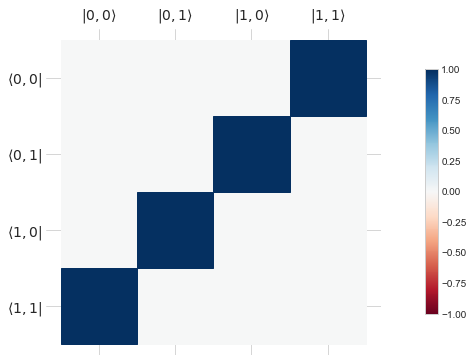

In [59]:
hinton(T)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1a80a160>)

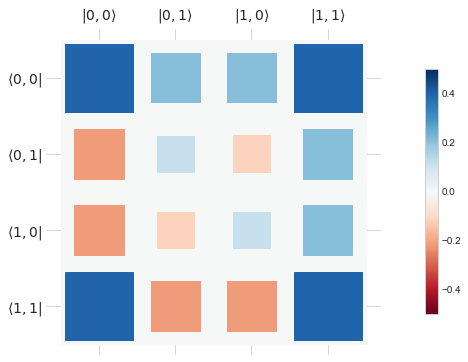

In [60]:
hinton(L_full_maker(res.x, dt))

In [61]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.4996574 +0.00000000e+00j -0.26674322-9.06471561e-05j
  -0.26674322+9.06471561e-05j  0.5003426 +0.00000000e+00j]
 [ 0.26674284+2.69127126e-04j  0.14191178+7.63171542e-04j
  -0.14269821-2.45087054e-04j -0.26674284-2.69127126e-04j]
 [ 0.26674284-2.69127126e-04j -0.14269821+2.45087054e-04j
   0.14191178-7.63171542e-04j -0.26674284+2.69127126e-04j]
 [ 0.5003426 +0.00000000e+00j  0.26674322+9.06471561e-05j
   0.26674322-9.06471561e-05j  0.4996574 +0.00000000e+00j]]

### Try

In [62]:
total_time = 10*pi/omega_1
time_steps = 2
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: -3.000016
         Iterations: 78
         Function evaluations: 184
[871.74930883 199.7730229 ]


In [63]:
res

 final_simplex: (array([[871.74930883, 199.7730229 ],
       [871.74930882, 199.77302291],
       [871.74930882, 199.7730229 ]]), array([-3.00001582, -3.00001582, -3.00001582]))
           fun: -3.0000158171734865
       message: 'Optimization terminated successfully.'
          nfev: 184
           nit: 78
        status: 0
       success: True
             x: array([871.74930883, 199.7730229 ])

In [64]:
F(res.x, dt)

-3.0000158171734865

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b61f128>)

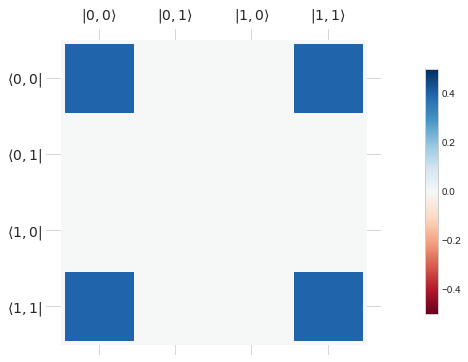

In [65]:
hinton(L_full_maker(res.x, dt))

In [66]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 4.99976746e-01+0.00000000e+00j -9.33335531e-04-3.03901624e-08j
  -9.33335531e-04+3.03901623e-08j  5.00023254e-01+0.00000000e+00j]
 [ 9.33342531e-04-3.49717910e-08j -2.19767312e-05+5.58590538e-06j
  -2.54647153e-05+3.75579702e-06j -9.33342531e-04+3.49717926e-08j]
 [ 9.33342531e-04+3.49717911e-08j -2.54647153e-05-3.75579702e-06j
  -2.19767312e-05-5.58590538e-06j -9.33342531e-04-3.49717926e-08j]
 [ 5.00023254e-01+0.00000000e+00j  9.33335531e-04+3.03901628e-08j
   9.33335531e-04-3.03901628e-08j  4.99976746e-01+0.00000000e+00j]]

### Try

In [67]:
total_time = 10*pi/omega_1
time_steps = 20
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[607.98305199  96.7451343  749.25107058 528.95695178 476.01309768
  18.3027505  880.68155245  69.2966738  532.38153764 954.36441666
 780.95674515 243.28618409 596.72306744 364.76053185 603.98425316
 744.04384332 962.71119073 407.75934536 821.73687004 211.2551181 ]


In [68]:
res

 final_simplex: (array([[607.98305199,  96.7451343 , 749.25107058, 528.95695178,
        476.01309768,  18.3027505 , 880.68155245,  69.2966738 ,
        532.38153764, 954.36441666, 780.95674515, 243.28618409,
        596.72306744, 364.76053185, 603.98425316, 744.04384332,
        962.71119073, 407.75934536, 821.73687004, 211.2551181 ],
       [607.9815692 ,  96.74443486, 749.24584155, 528.96378545,
        476.01271613,  18.30289169, 880.68132337,  69.29497004,
        532.38417556, 954.36010249, 780.95960601, 243.28703731,
        596.72100947, 364.76741335, 603.9714959 , 744.04243967,
        962.7229397 , 407.7598848 , 821.73458787, 211.25199095],
       [607.98211847,  96.74264848, 749.24525079, 528.96595401,
        476.01266725,  18.30302057, 880.68088264,  69.29567187,
        532.38585879, 954.36385643, 780.9546415 , 243.28636974,
        596.72449899, 364.76205084, 603.97560196, 744.03997675,
        962.72276396, 407.76047081, 821.73236218, 211.25376217],
       [607.98106645

In [74]:
res.success

False

In [76]:
res.nit

3057

In [78]:
res.nfev

4000

In [79]:
res.status

1

In [80]:
res.message

'Maximum number of function evaluations has been exceeded.'

In [69]:
F(res.x, dt)

-3.000060094439143

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b698748>)

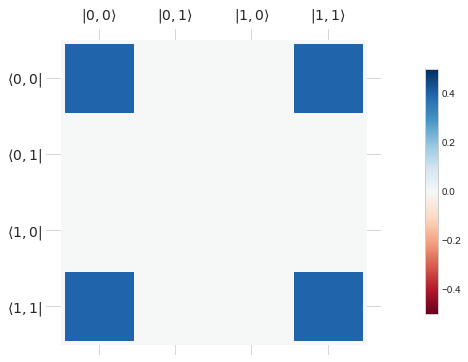

In [70]:
hinton(L_full_maker(res.x, dt))

In [71]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 5.00009297e-01+0.00000000e+00j -9.30270618e-04-7.33362683e-06j
  -9.30270618e-04+7.33362683e-06j  4.99990703e-01+0.00000000e+00j]
 [ 9.30268257e-04+2.98353242e-06j -7.15195238e-07+2.72898589e-05j
  -3.99468733e-06-1.53233804e-05j -9.30268257e-04-2.98353242e-06j]
 [ 9.30268257e-04-2.98353242e-06j -3.99468733e-06+1.53233804e-05j
  -7.15195238e-07-2.72898589e-05j -9.30268257e-04+2.98353242e-06j]
 [ 4.99990703e-01+0.00000000e+00j  9.30270618e-04+7.33362683e-06j
   9.30270618e-04-7.33362683e-06j  5.00009297e-01+0.00000000e+00j]]

### Try

In [128]:
total_time = 10*pi/omega_1
time_steps = 20
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True, 
                                 'maxiter': 1e6, 'maxfev':1e6,})
print(res.x)

Optimization terminated successfully.
         Current function value: -8.000000
         Iterations: 551
         Function evaluations: 1446
[543.49177128 930.66927382 217.33464452 491.57997683 506.25648449
  37.84652109 120.84993096 499.46740961 919.76726289 785.1793033
 548.28526015 548.11367753 890.13524084 684.39735937 871.4655425
 840.52557688  12.63323009  31.4185623  222.16477877 584.71312157]


In [129]:
res

 final_simplex: (array([[543.49177128, 930.66927382, 217.33464452, 491.57997683,
        506.25648449,  37.84652109, 120.84993096, 499.46740961,
        919.76726289, 785.1793033 , 548.28526015, 548.11367753,
        890.13524084, 684.39735937, 871.4655425 , 840.52557688,
         12.63323009,  31.4185623 , 222.16477877, 584.71312157],
       [543.49177128, 930.66927382, 217.33464452, 491.57997683,
        506.25648449,  37.84652109, 120.84993096, 499.46740961,
        919.76726289, 785.1793033 , 548.28526015, 548.11367753,
        890.13524084, 684.39735937, 871.4655425 , 840.52557688,
         12.63323009,  31.4185623 , 222.16477877, 584.71312157],
       [543.49177128, 930.66927382, 217.33464452, 491.57997683,
        506.25648449,  37.84652109, 120.84993096, 499.46740961,
        919.76726289, 785.1793033 , 548.28526015, 548.11367753,
        890.13524084, 684.39735937, 871.4655425 , 840.52557688,
         12.63323009,  31.4185623 , 222.16477877, 584.71312157],
       [543.49177128

In [130]:
res.success

True

In [131]:
res.nit

551

In [132]:
res.nfev

1446

In [133]:
res.status

0

In [134]:
res.message

'Optimization terminated successfully.'

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1a36bbe0>)

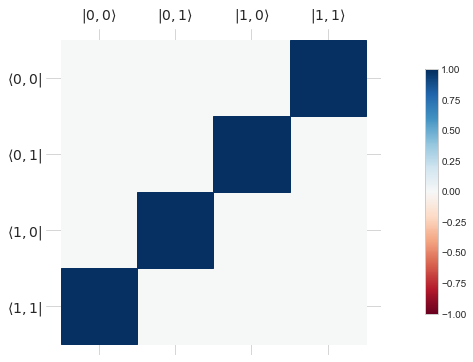

In [135]:
hinton(T)

In [136]:
F(res.x, dt)

-8.00000000000723

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1bee2550>)

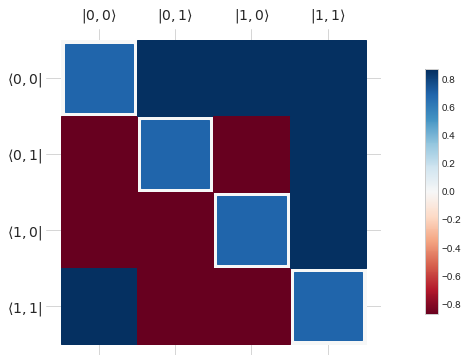

In [137]:
hinton(L_full_maker(res.x, dt))

In [138]:
L_full_maker(res.x, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.13071504+0.00000000e+00j -0.33396807+4.57597193e-02j
  -0.33396807-4.57597193e-02j  0.86928496+0.00000000e+00j]
 [ 0.33396806-4.57597537e-02j  0.1258974 -3.51606008e-02j
  -0.86928496+8.96735047e-08j -0.33396806+4.57597537e-02j]
 [ 0.33396806+4.57597537e-02j -0.86928496-8.96735061e-08j
   0.1258974 +3.51606008e-02j -0.33396806-4.57597537e-02j]
 [ 0.86928496+0.00000000e+00j  0.33396807-4.57597193e-02j
   0.33396807+4.57597193e-02j  0.13071504+0.00000000e+00j]]

### Try

In [73]:
total_time = 10*pi/omega_1
time_steps = 50
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

KeyboardInterrupt: 

In [ ]:
res

In [ ]:
F(res.x, dt)

In [ ]:
hinton(L_full_maker(res.x, dt))

In [ ]:
L_full_maker(res.x, dt)

### Try

In [52]:
total_time = 10*pi/omega_1
time_steps = 70
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

KeyboardInterrupt: 

In [ ]:
F(res.x, dt)

In [ ]:
hinton(L_full_maker(res.x, dt))

In [ ]:
L_full_maker(res.x, dt)

### Try

In [ ]:
total_time = 4*pi/omega_1
time_steps = 50
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

In [ ]:
F(res.x, dt)

In [ ]:
hinton(L_full_maker(res.x, dt))

In [ ]:
L_full_maker(res.x, dt)

### Try

In [ ]:
total_time = 10*pi/omega_1
time_steps = 100
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

In [ ]:
F(res.x, dt)

In [ ]:
hinton(L_full_maker(res.x, dt))

In [ ]:
L_full_maker(res.x, dt)

# Running stuff

### Try1

In [114]:
total_time = pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1163cf6a0>)

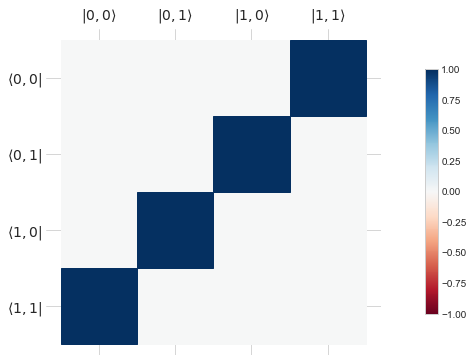

In [8]:
hinton(T)

In [115]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([253.12809151+0.j, 843.88141913+0.j, 670.69241692+0.j,
       924.100077  +0.j, 342.69688787+0.j, 123.45758492+0.j,
       879.26165155+0.j, 520.4459173 +0.j, 339.72130347+0.j,
       984.45194508+0.j,  64.74984188+0.j,  81.10046078+0.j,
         2.82873766+0.j, 265.22266621+0.j, 207.7809171 +0.j,
       834.24591251+0.j, 964.13437576+0.j, 875.54876982+0.j,
       129.61146026+0.j, 466.77550287+0.j])

In [117]:
F(xi_opt, dt)

-3.9789212334927573

In [118]:
max_iter

10

In [120]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [122]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.28233594+0.j         -0.16005333-0.00893544j -0.16005333+0.00893544j
   0.71766406+0.j        ]
 [ 0.14342862-0.05006893j -0.05447685+0.00321831j -0.30317032+0.17678044j
  -0.14342862+0.05006893j]
 [ 0.14342862+0.05006893j -0.30317032-0.17678044j -0.05447685-0.00321831j
  -0.14342862-0.05006893j]
 [ 0.71766406+0.j          0.16005333+0.00893544j  0.16005333-0.00893544j
   0.28233594+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b792400>)

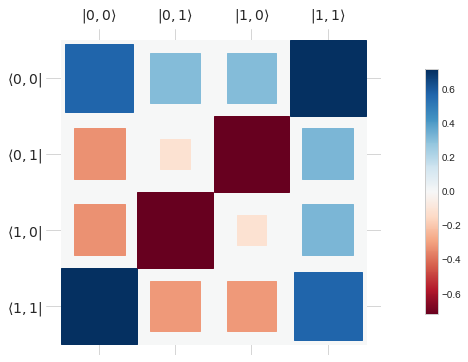

In [123]:
hinton(L_full_maker(xi_opt, dt))

# Next chapter

## memory clear (uses regex, so be careful)

In [7]:
%reset_selective -f var1, var2  # replace var1, var2 with your defined ones

## sub topic 2

In [8]:
cnot()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

## sub topic 3

### sub sub topic 1